In [5]:
import os
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Subset

from VAE_models import Exp2VariationalAutoEncoder

# BraTS2020 Data files structure
# data
# ├── test
# │   ├── healthy_test_images.npy
# │   ├── unhealthy_test_images.npy
# ├── |── unhealthy_test_masks.npy
# ├── train
# │   ├── healthy_train_images.npy

class BraTS2020Dataset(Dataset):
    def __init__(self, root_dir, train=True, healthy=True, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            train (bool): True to load training data, False for test data.
            healthy (bool): True to load healthy images, False for unhealthy.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.train = train
        self.healthy = healthy
        self.transform = transform
        self.data = None
        self.load_data(root_dir)

    def load_data(self, root_dir):
        # Construct file path based on the provided arguments
        data_type = 'train' if self.train else 'test'
        health_status = 'healthy' if self.healthy else 'unhealthy'
        file_name = f'{health_status}_{data_type}_images.npy'
        
        # Load the data
        file_path = f'{root_dir}/{data_type}/{file_name}'
        self.data = np.load(file_path)

        # Check the data shape
        print(f"Loaded {data_type} data with shape: {self.data.shape}")
        
        # For unhealthy test data, we could also load masks here if needed
        if not self.train and not self.healthy:
            mask_file_path = f'{root_dir}/{data_type}/unhealthy_test_masks.npy'
            self.masks = np.load(mask_file_path)
        else:
            self.masks = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        # Check the image shape
        # print(f"Image shape: {image.shape}")
        
        if self.transform:
            image = self.transform(image)
        
        sample = {'image': image}
        
        # Include masks in the sample if this is unhealthy test data
        if self.masks is not None:
            mask = self.masks[idx]
            if self.transform:
                mask = self.transform(mask)
            sample['mask'] = mask

        return sample

def load_dataset(data_dir, dataset_class, batch_size=32, train=True, healthy=True, shuffle=True):
    # Define the transforms
    data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((64, 64)),
    ])
    # Load the dataset
    dataset = dataset_class(data_dir, train=train, healthy=healthy, transform=data_transforms)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0, pin_memory=True)
    return data_loader

def get_train_val_dataloader(dataset, fold_idx, k=5):
    indices = list(range(len(dataset)))
    
    val_split = int(np.floor(len(dataset) / k))
    train_indices, val_indices = indices[:fold_idx * val_split] + indices[(fold_idx + 1) * val_split:], indices[fold_idx * val_split:(fold_idx + 1) * val_split]
    
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)

    train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, num_workers=0, pin_memory=True)
    
    return train_loader, val_loader

def qr_loss(x, q1, q2, mu, logvar, qval1=0.15, qval2=0.5):
    # Quantile Regression Loss
    q1_loss = torch.sum(torch.max(qval1 * (x - q1), (qval1 - 1) * (x - q1)))
    q2_loss = torch.sum(torch.max(qval2 * (x - q2), (qval2 - 1) * (x - q2)))
    recon_loss = q1_loss + q2_loss
    kld_loss = -torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld_loss

def train_qr_vae_incremental(device, model, train_loader, val_loader, optimizer, epochs=10, save_checkpoint=True, checkpoint_dic_path='checkpoints/', checkpoint_range=(100, 200), checkpoint_interval=1):
    start_epoch = 0
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    # Load checkpoint if exists
    checkpoint_path = f'{checkpoint_dic_path}/checkpoint.pt'
    losses_path = f'{checkpoint_dic_path}/losses.pt'

    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        # Move optimizer's state_dict to the correct device after loading
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(device)
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint['best_val_loss']
        print(f"Resuming training from epoch {start_epoch} with best loss {best_val_loss:.4f}")
        if os.path.exists(losses_path):
            losses_checkpoint = torch.load(losses_path)
            train_losses = losses_checkpoint['train_losses'][0:start_epoch]
            val_losses = losses_checkpoint['val_losses'][0:start_epoch]
            print(f"Loaded losses from file.")

    model.to(device)
    # print("Model loaded to device.")
    
    # Load all data to device before training to speed up the process
    train_sample = next(iter(train_loader))
    train_data = train_sample['image'].to(device)
    train_data_size = len(train_data)
    print(f"Train data shape: {train_data.shape}")

    val_sample = next(iter(val_loader))
    val_data = val_sample['image'].to(device)
    val_data_size = len(val_data)
    print(f"Validation data shape: {val_data.shape}")
    
    print("Training started.")
    for epoch in (pb := tqdm(range(start_epoch, epochs))):
        model.train()

        # Training
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(train_data)
        train_loss = qr_loss(train_data, recon_batch[0], recon_batch[1], mu, logvar)
        train_loss.backward()
        optimizer.step()
        
        avg_train_loss = train_loss.item() / train_data_size
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        with torch.no_grad():
            recon_batch, mu, logvar = model(val_data)
            val_loss = qr_loss(val_data, recon_batch[0], recon_batch[1], mu, logvar)
            avg_val_loss = val_loss.item() / val_data_size
            val_losses.append(avg_val_loss)

        # print(f'====> Epoch: {epoch} Average Training loss: {avg_train_loss:.4f} Validation loss: {avg_val_loss:.4f}')
        # Print the losses beside the progress bar
        pb.set_postfix(train_loss=f'{avg_train_loss:.4f}', val_loss=f'{avg_val_loss:.4f}')

        # Checkpoint saved if the loss is improved
        if save_checkpoint and avg_val_loss < best_val_loss and epoch >= checkpoint_range[0] and epoch <= checkpoint_range[1] and epoch % checkpoint_interval == 0:
            best_val_loss = avg_val_loss
            
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
            }, checkpoint_path)
            torch.save({'train_losses': train_losses, 'val_losses': val_losses}, losses_path)
            # print("Checkpoint saved.")

    # Save the losses
    torch.save({'train_losses': train_losses, 'val_losses': val_losses}, losses_path)

    print("Training completed.")

def train_qr_vae_incremental_kfold(device, dataset, epochs=10, k_fold = 5, save_checkpoint=True, checkpoint_dic_path='checkpoints/', checkpoint_ranges=None, checkpoint_interval=1):
    os.makedirs(checkpoint_dic_path, exist_ok=True)
    for fold_idx in range(5):
        train_loader, val_loader = get_train_val_dataloader(dataset, fold_idx, k_fold)

        model = Exp2VariationalAutoEncoder()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        checkpoint_dic_path_fold = f'{checkpoint_dic_path}/fold_{fold_idx}'
        os.makedirs(checkpoint_dic_path_fold, exist_ok=True)

        if checkpoint_ranges[fold_idx] == None:
            checkpoint_ranges[fold_idx] = (0, epochs)

        train_qr_vae_incremental(device, model, train_loader, val_loader, optimizer, epochs, save_checkpoint, checkpoint_dic_path_fold, checkpoint_ranges[fold_idx], checkpoint_interval)


def load_and_plot_losses(start, end, checkpoint_dic_path='checkpoints/', k_fold=5):
    for fold_idx in range(k_fold):
        checkpoint_dic_path_fold = f'{checkpoint_dic_path}/fold_{fold_idx}'
        losses_path = f'{checkpoint_dic_path_fold}/losses.pt'
        checkpoint = torch.load(losses_path)
        train_losses = checkpoint['train_losses'][start:end]
        val_losses = checkpoint['val_losses'][start:end]
        # Print the best validation loss and the corresponding epoch
        print(f"Fold {fold_idx} Best Validation Loss: {min(val_losses):.4f} at Epoch {np.argmin(val_losses) + start}")
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title(f'Fold {fold_idx} Losses')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()


In [2]:
data_dir = 'data'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
])
dataset = BraTS2020Dataset(data_dir, train=True, healthy=True, transform=data_transforms)

Using device: cuda
Loaded train data with shape: (973, 240, 240, 3)


In [7]:
# Start saving checkpoints after epoch 2000
NUM_EPOCHS = 4000
checkpoint_ranges = []
for fold_idx in range(5):
    checkpoint_ranges.append((2000, NUM_EPOCHS))
train_qr_vae_incremental_kfold(device, dataset, epochs=NUM_EPOCHS, k_fold = 5, save_checkpoint=True, checkpoint_dic_path='checkpoints/', checkpoint_ranges=checkpoint_ranges, checkpoint_interval=50)

c:\Users\lvyou\anaconda3\envs\ML\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train data shape: torch.Size([779, 3, 64, 64])
Validation data shape: torch.Size([194, 3, 64, 64])
Training started.


100%|██████████| 5000/5000 [07:59<00:00, 10.42it/s, train_loss=139.5657, val_loss=244.7487]


Training completed.
Resuming training from epoch 2751 with best loss 190.5125
Loaded losses from file.
Train data shape: torch.Size([779, 3, 64, 64])
Validation data shape: torch.Size([194, 3, 64, 64])
Training started.


100%|██████████| 2249/2249 [03:36<00:00, 10.37it/s, train_loss=142.0315, val_loss=192.2476]


Training completed.
Resuming training from epoch 2951 with best loss 201.1526
Loaded losses from file.
Train data shape: torch.Size([779, 3, 64, 64])
Validation data shape: torch.Size([194, 3, 64, 64])
Training started.


100%|██████████| 2049/2049 [03:17<00:00, 10.38it/s, train_loss=138.7357, val_loss=208.4930]


Training completed.
Resuming training from epoch 2351 with best loss 202.8565
Loaded losses from file.
Train data shape: torch.Size([779, 3, 64, 64])
Validation data shape: torch.Size([194, 3, 64, 64])
Training started.


100%|██████████| 2649/2649 [04:14<00:00, 10.42it/s, train_loss=137.0255, val_loss=207.7159]


Training completed.
Resuming training from epoch 2251 with best loss 189.8727
Loaded losses from file.
Train data shape: torch.Size([779, 3, 64, 64])
Validation data shape: torch.Size([194, 3, 64, 64])
Training started.


100%|██████████| 2749/2749 [04:24<00:00, 10.41it/s, train_loss=138.6903, val_loss=190.5883]

Training completed.


Fold 0 Best Validation Loss: 230.0798 at Epoch 3252


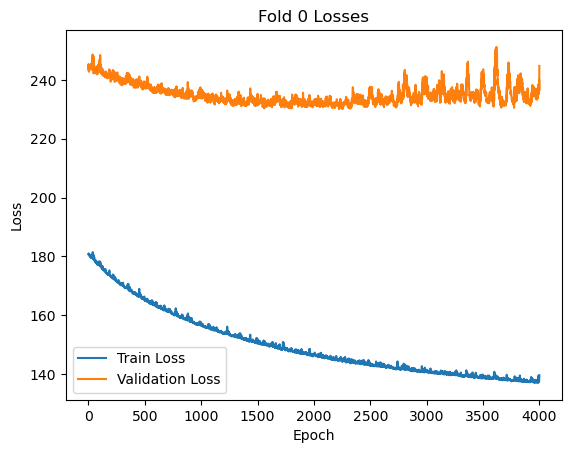

Fold 1 Best Validation Loss: 188.6752 at Epoch 3792


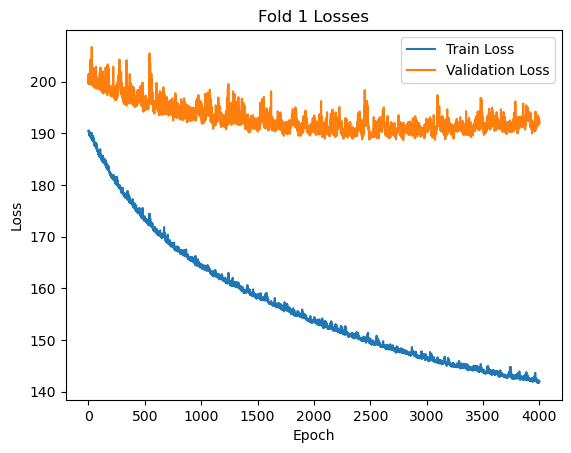

Fold 2 Best Validation Loss: 199.7297 at Epoch 2071


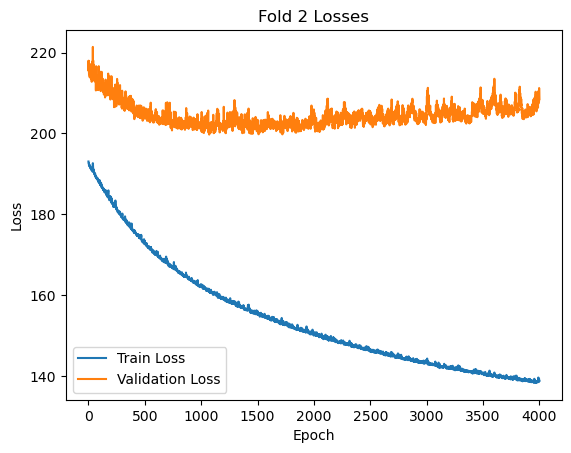

Fold 3 Best Validation Loss: 202.2240 at Epoch 2662


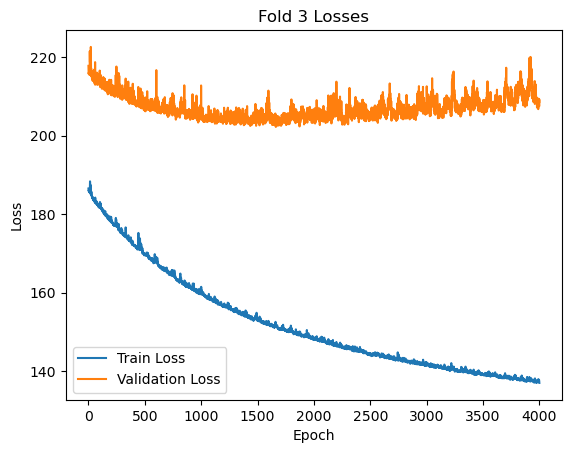

Fold 4 Best Validation Loss: 188.7065 at Epoch 2881


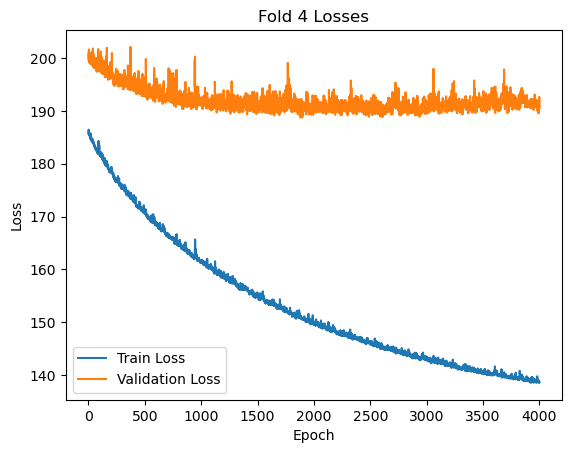

In [8]:
load_and_plot_losses(1000, NUM_EPOCHS, checkpoint_dic_path='checkpoints/', k_fold=5)

Loaded test data with shape: (243, 240, 240, 3)
Model loaded from checkpoint.


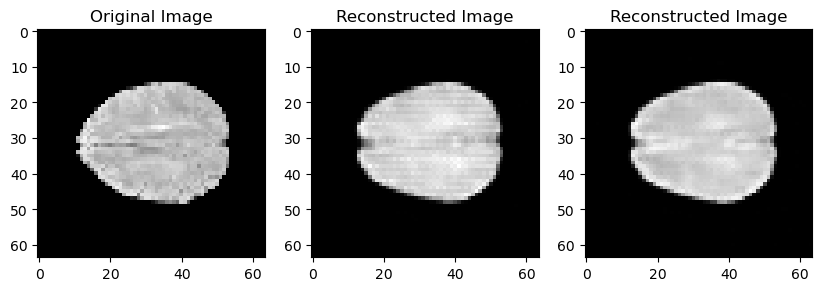

Model loaded from checkpoint.


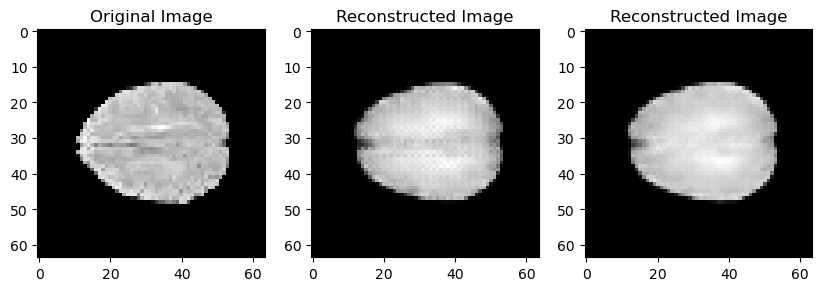

Model loaded from checkpoint.


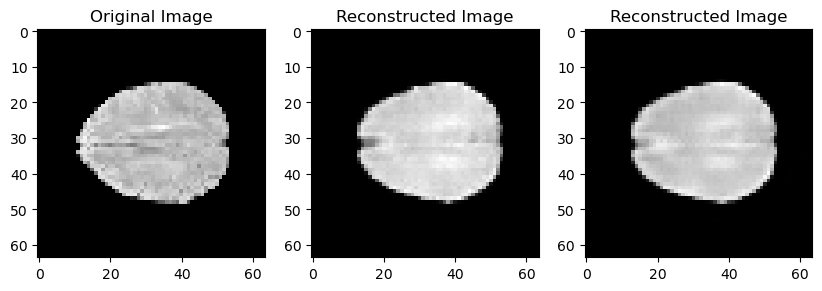

Model loaded from checkpoint.


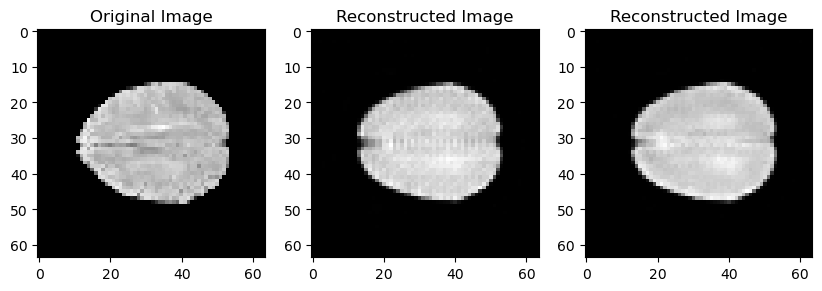

Model loaded from checkpoint.


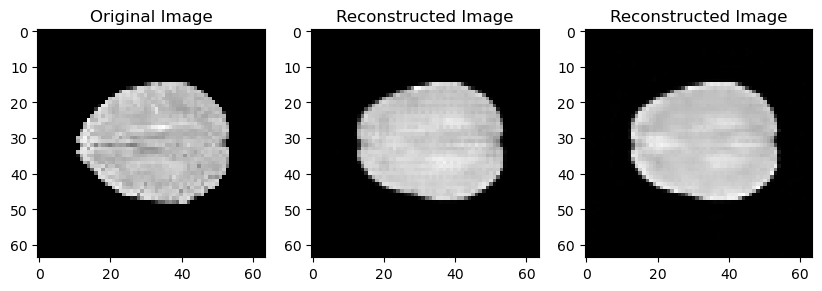

In [9]:
checkpoint_path_idx = 0
test_data_loader = load_dataset(data_dir, BraTS2020Dataset, train=False, healthy=True, batch_size=1)
sample = next(iter(test_data_loader))
for checkpoint_path_idx in range(5):
    checkpoint_path = f'checkpoints/fold_{checkpoint_path_idx}/checkpoint.pt'

    # Load the best model
    checkpoint = torch.load(checkpoint_path)
    model = Exp2VariationalAutoEncoder().to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Model loaded from checkpoint.")

    # Test the model on one picture
    model.eval()
    with torch.no_grad():
        train_data = sample['image'].to(device)
        (q1, q2), mu, logvar = model(train_data)
        # Plot the original image
        plt.figure(figsize=(10, 6))
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        # show the first channel of the image
        first_channel = train_data.cpu().numpy().squeeze()[0]
        plt.imshow(first_channel, cmap='gray')
        # Plot the reconstructed image
        plt.subplot(1, 3, 2)
        plt.title("Reconstructed Image")
        first_channel = q1.cpu().numpy().squeeze()[0]
        plt.imshow(first_channel, cmap='gray')
        # Plot the reconstructed image
        plt.subplot(1, 3, 3)
        plt.title("Reconstructed Image")
        first_channel = q2.cpu().numpy().squeeze()[0]
        plt.imshow(first_channel, cmap='gray')
        plt.show()
